In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

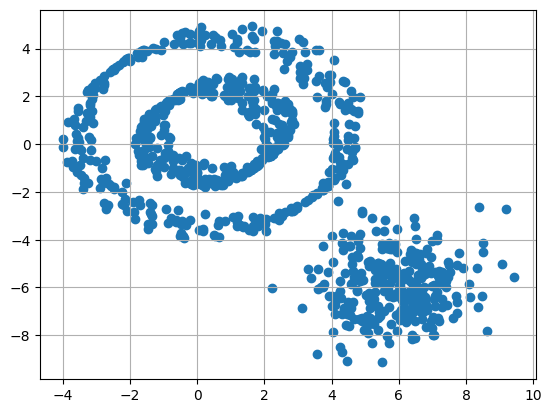

In [4]:
df = pd.read_csv("..\\Datasets\\Circle.csv")
sigma = 1
distance_matrix = euclidean_distances(df.values)
similarity_matrix = np.exp(-distance_matrix**2/(2*sigma**2))

plt.scatter(df.values[:, 0], df.values[:, 1])
plt.grid()
plt.show()

In [ ]:
k = 10
for i, row in enumerate(similarity_matrix):
    ndx_max  = np.argsort(row)[::-1][:k]
    for j in range(row.size):
        if j not in ndx_max:
            similarity_matrix[i, j] = 0 if i not in np.argsort(similarity_matrix[j])[::-1][:k] else similarity_matrix[i, j]

simila_ = similarity_matrix.copy()
print(simila_.shape)

(899, 899)


In [24]:
#Equal to aboe but faster
k = 10
nearest_neighbors = np.argsort(similarity_matrix, axis = 1)[: ,::-1][:, : k]
print(nearest_neighbors.shape)
S = np.copy(similarity_matrix)
k = 40
for i, row in enumerate(S):
    for j in range(row.size):
        if j not in nearest_neighbors[i, :]:
            S[i, j] = 0 if i not in nearest_neighbors[j, :] else S[i, j]

print(S)

(899, 10)
[[1.         0.         0.99618086 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.99618086 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [12]:
np.allclose(similarity_matrix, similarity_matrix, atol = 1e-10)

True

In [25]:
weight  = S- np.identity(df.values.shape[0])
print(weight[:5, :5])

[[0.         0.         0.99618086 0.95032674 0.        ]
 [0.         0.         0.         0.         0.99523268]
 [0.99618086 0.         0.         0.93295982 0.        ]
 [0.95032674 0.         0.93295982 0.         0.        ]
 [0.         0.99523268 0.         0.         0.        ]]


In [26]:
degree_matrix = np.diag(weight.sum(axis = 1))
print(degree_matrix)

[[9.41130447 0.         0.         ... 0.         0.         0.        ]
 [0.         8.51388443 0.         ... 0.         0.         0.        ]
 [0.         0.         9.42880939 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 7.75586408 0.         0.        ]
 [0.         0.         0.         ... 0.         9.73727354 0.        ]
 [0.         0.         0.         ... 0.         0.         6.96240935]]


In [27]:
W  = csr_matrix(weight)
D = csr_matrix(degree_matrix)
L = D - W 
elle = degree_matrix - weight

In [17]:
#Eigenvalues and eigenvectors Test for testing below

eigenv = np.linalg.eigvals(elle)
#print(np.sort(eigenv))

In [11]:
def inverse_power_method(A, mu, tol = 1e-8, max_iter = 1000):
    """
    Inverse power method applied to the matrix A shifted by a factor mu*I. 
    Returns the smallest eigenvalue of A and the associated eigenvector
    """

    n = A.shape[0]
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    I = np.eye(n)
    
    for k in range(max_iter):
        y = np.linalg.solve(A - mu * I, v)                          #Solve (A - mu * I) * v_new = v_old
        v_new = y / np.linalg.norm(y)
        lambda_k = (v_new.T @ A @ v_new).item()
        if np.linalg.norm(A @ v_new - lambda_k * v_new) < tol:      #We accept just a treshold of equality, due to numerical cancellation
            return lambda_k, v
        v = v_new


In [11]:
#def deflation_inverse_power_method(A,M=4,mu=0,tol=1e-8,max_iter=1000):
    #n= A.shape[0]
    #e1= np.zeros(n).T
    #e1[0]= 1
    #Actual_A= A.copy()
    #P= np.zeros((n,n))
    #eigenvalues= []
    #for i in range(M):
        #min_lamda_i, x_i = inverse_power_method(Actual_A,mu)
        #eigenvalues.append(min_lamda_i)
        #P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
        #B_bar_i= P_bar_i @ Actual_A @ P_bar_i
        #Actual_A= B_bar_i[1:,1:]
        #P[i,i]= min_lamda_i
    
    #return eigenvalues 

#defl_eigenvalues= deflation_inverse_power_method(L, k)
#print(defl_eigenvalues)

In [8]:
def deflation_inverse_power_method(A,M=4,mu=0,tol=1e-8,max_iter=1000, compute_eigenvectors= 'off'):
    n= A.shape[0]
    e1= np.zeros(n).T
    e1[0]= 1
    Actual_A= A.copy()
    E= np.zeros((n,n))
    B_prec= np.zeros((n,n))
    P_prec= np.zeros((n,n))
    Actual_vector= np.zeros((1,n))
    eigenvalues= []
    eigenvectors= []
    if compute_eigenvectors == 'off':
        P= np.zeros((n,n))
        eigenvalues= []
        for i in range(M):
            min_lamda_i, x_i = inverse_power_method(Actual_A,mu)
            eigenvalues.append(min_lamda_i)
            P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
            B_bar_i= P_bar_i @ Actual_A @ P_bar_i
            Actual_A= B_bar_i[1:,1:]
            P[i,i]= min_lamda_i
        return eigenvalues
    else:
        for i in range(M):
            if i == 0:
                try:
                    min_eigenvalue_i, x_i= inverse_power_method(A, mu=0)
                except np.linalg.LinAlgError:
                    min_eigenvalue_i, x_i= inverse_power_method(A, mu=1e-6)
                eigenvalues.append(min_eigenvalue_i)
                eigenvectors.append(x_i)
                Actual_vector = x_i
                P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
                B_bar_i= P_bar_i @ Actual_A @ P_bar_i
                Actual_A= B_bar_i[1:,1:]
                E[i,i]= min_eigenvalue_i
                P_prec = P_bar_i
                B_prec = B_bar_i
            else:
                E[i,i]= min_eigenvalue_i
                P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
                B_bar_i= P_bar_i @ Actual_A @ P_bar_i
                Actual_A= B_bar_i[1:,1:]
                try:
                    min_eigenvalue_i,_= inverse_power_method(Actual_A,mu=0)
                except np.linalg.LinAlgError:
                    min_eigenvalue_i,_= inverse_power_method(Actual_A, mu=1e-6)
                eigenvalues.append(min_eigenvalue_i)
                P_i= np.zeros((n,n))
                for k in range(0,i):
                    P_i[k,k]= 1
                P_i[i+1:,i+1:]= P_bar_i
                B_i= P_i @ B_prec @ P_i
                first_parameter= B_prec[i-1,i:]*Actual_vector/(eigenvalues[i-1]-min_eigenvalue_i)
                new_vector= np.zeros((1,n-i-1))
                new_vector[0]= first_parameter
                new_vector[1:]= Actual_vector
                Actual_A= new_vector
                for j in range(0,i-1,-1):
                    parameter= B_prec[j,j:]*Actual_A/(eigenvalues[j-1]-min_eigenvalue_i)
                    new_vector= np.zeros((1,j-1))
                    new_vector[0]= parameter
                    new_vector[1:]= Actual_vector
                    Actual_vector= new_vector
                eigenvectors.append(Actual_vector)
        return eigenvalues,eigenvectors

In [13]:
test_eigenvalues= eigenv[:k]
print(np.allclose(test_eigenvalues,defl_eigenvalues, atol= 0.9))        #0.9 is the first value from which arrays are considered equal

NameError: name 'defl_eigenvalues' is not defined

In [20]:
def power_method(A, mu = 0, tol = 1e-8, max_iter = 1000):
    """
    Inverse power method applied to the matrix A shifted by a factor mu*I. 
    Returns the smallest eigenvalue of A and the associated eigenvector
    """
    print(A.shape)
    n = A.shape[0]
    v = np.random.rand(n, 1)
    v = v / np.linalg.norm(v)
    I = np.eye(n)
    
    for k in range(max_iter):
        #Solve (A - mu * I) * v_new = v_old
        y = (A - mu * I) @ v
        v_new = y / np.linalg.norm(y)
        lambda_k = (v_new.T @ A @ v_new).item()                             #copy an element of an array in standard python scalar and return it
        v_new =v_new.reshape((n,1))
        if np.linalg.norm(A @ v_new - lambda_k * v_new) < tol:
            return lambda_k, v_new
            break
        else:
            v = v_new
            continue

print(power_method(L))

(899, 899)
(29.30883462426535, matrix([[-2.80149735e-11],
        [-4.22423773e-12],
        [-7.07793549e-12],
        [-7.43115640e-11],
        [-3.35110094e-12],
        [ 6.11455794e-12],
        [-5.47057006e-11],
        [ 3.58052248e-10],
        [ 3.64852321e-10],
        [ 8.36530142e-12],
        [ 1.39569681e-10],
        [-2.26598929e-10],
        [-4.14172194e-11],
        [ 2.10626225e-11],
        [ 6.67711284e-12],
        [ 1.62187769e-11],
        [-2.30506457e-10],
        [ 4.53779528e-12],
        [-2.40585309e-10],
        [-2.26482790e-12],
        [ 6.70158356e-12],
        [-9.88772808e-12],
        [-2.41367869e-10],
        [-1.46490781e-11],
        [-9.20109505e-12],
        [-8.00283334e-12],
        [ 1.26281564e-11],
        [ 8.56029683e-11],
        [-6.01148047e-12],
        [ 6.86564179e-11],
        [-2.61009166e-12],
        [-1.10756126e-11],
        [ 2.79741701e-12],
        [-4.68828591e-12],
        [ 4.03101494e-11],
        [ 2.64090541e-11

In [21]:
def shifting_small_method(A, M, tol = 1e-8):
    """
    Shifting method applied to the symmetric matrix A in order to find the smallest M eigenvalues and 
    corresponding eigenvectors of A.
    A: symmetric matrix for which we want to return the eigenvalues
    M: number of small eigenvalues to compute
    tol: tolerance of the inverse power method
    Returns the M smallest eigenvalues and the corresponding eigenvectors.
    """
    eigenvalues = []
    eigenvectors = []
    A_current = A.copy()
    n = A.shape[0]
    """
    try:
        gamma, _ = power_method(A_current, 0, tol, max_iter = 1000)
    except np.linalg.LinAlgError:
        mu = 1e-6
        gamma, _ = power_method(A_current, mu, tol, max_iter = 1000)
    """
    
    #gamma = 10 * M/n * gamma
    gamma = 100
    if M > n:
        raise np.linalg.LinAlgError(f"{n}-squared cannot have {M} eigenvalues")

    for i in range(M):
        try:
            #first try to apply inverse power method without shifting the matrix A (mu = 0)
            eigenvalue_i, eigenvector_i = inverse_power_method(A_current, 0, tol, max_iter = 1000) 
        except np.linalg.LinAlgError:
            #if LinAlgError occurs (singular matrix, eigenvalue equal to 0), then matrix A is shifted by a small quantity mu to allow the computation
            mu = 1e-6
            eigenvalue_i, eigenvector_i = inverse_power_method(A_current, mu, tol, max_iter = 1000) 
        eigenvalues.append(eigenvalue_i)
        eigenvectors.append(eigenvector_i)
        print(eigenvector_i.size)
        #delete the contribute along the rank 1 matrix eigenvector_i*eigenvector_i.T
        A_current = A_current  - eigenvalue_i * np.outer(eigenvector_i, eigenvector_i) #it could be a problem for the conditioning number of the next iterations (no prob if i compute the maximum eigenvalue)
        A_current = A_current  + gamma * np.outer(eigenvector_i, eigenvector_i)
    print(len(eigenvectors))
    return np.array(eigenvalues), np.array(eigenvectors).T

A = np.array([[2, 1], [1, 2]])
eigenval, eigenvec = shifting_small_method(L, 10)


899
899
899
899
899
899
899
899
899
899
10


In [24]:
print(eigenvec.shape)

(899, 10)


In [25]:
eigen_val, eigenvec_ = np.linalg.eig(elle)
print(np.allclose(eigenvec_[:, np.argsort(eigen_val)[:10]], np.array(eigenvec), atol = 0.2))
print(np.linalg.norm(eigenvec_[:, np.argsort(eigen_val)[:10]] - np.array(eigenvec)))
print(eigen_val)

True
4.715467962018575
[ 5.68989300e-16  3.40748373e-02  6.33690222e-02  1.75672231e-01
  1.98896694e-01  3.89340119e-01  4.06052897e-01  7.12276443e-01
  6.28199618e-01  9.24152121e-01  1.06767073e+00  1.25441028e+00
  1.34237803e+00  1.44451001e+00  1.58453728e+00  1.98948335e+00
  2.16659803e+00  2.32365092e+00  2.29703929e+00  2.39859312e+00
  2.76556819e+00  2.92272723e+00  3.51780208e+00  3.40638427e+00
  3.30204802e+00  3.71141817e+00  3.93644260e+00  4.21438563e+00
  1.60234456e+01  1.58303057e+01  1.56940012e+01  4.31137274e+00
  4.65953085e+00  5.10453288e+00  5.32362540e+00  5.36504820e+00
  5.40504827e+00  1.51930933e+01  5.78694786e+00  5.87107442e+00
  1.51370166e+01  6.11023695e+00  6.20621920e+00  6.25816646e+00
  1.48957796e+01  1.49297490e+01  1.49981716e+01  1.49896498e+01
  1.47183146e+01  1.45329735e+01  1.46103247e+01  1.44888962e+01
  1.44286764e+01  1.43373894e+01  1.43445105e+01  1.42233135e+01
  1.42637095e+01  1.41969953e+01  1.41481675e+01  1.41190327e+01
  

In [26]:
def deflation_small_method(A, M, tol):
    eigenvalues = np.zeros(n)
    eigenvectors = []
    A_current = A.copy()
    n = A.shape[0]
    I = np.eye(n)
    
    
    try:
        lambda_, v = inverse_power_method(A_current, 0, tol, max_iter = 1000) 
    except np.linalg.LinAlgError:
        mu = 1e-6
        lambda_, v = inverse_power_method(A_current, mu, tol, max_iter = 1000) 
    
    eigenvalues[0] = lambda_
    eigenvectors.append(lambda_)

    for k in range(M):
        dim = n - k
        e1 = np.zeros((dim, 1))
        e1[0] = 1
        P = np.diag(eigenvalues)
        P_til = - e1 @ v
        P[k + 1: , k + 1, :] = P_til
        B = P @ A_current @ P


In [1]:
def create_L(X, k):
    distance_matrix = euclidean_distances(X)
    similarity_matrix = np.exp(-distance_matrix**2/(2*sigma**2))
    for i, row in enumerate(similarity_matrix):
        ndx_max  = np.argsort(row)[::-1][:k]
        for j in range(row.size):
            if j not in ndx_max:
                similarity_matrix[i, j] = 0 if i not in np.argsort(similarity_matrix[j])[::-1][:k] else similarity_matrix[i, j]
    weight  = similarity_matrix - np.identity(X.shape[0])
    degree_matrix = np.diag(weight.sum(axis = 1))
    return degree_matrix - weight 


In [32]:
print(np.allclose(elle, L, atol = 1e-8))

True


In [28]:
print(np.allclose(elle, L, atol = 1e-8))

NotImplementedError: subtracting a sparse array from a nonzero scalar is not supported

In [5]:
L10 = create_L(df.values, 10)
L20 = create_L(df.values, 20)
L40 = create_L(df.values, 40)

In [6]:
L10 = csr_matrix(L10)
L20 = csr_matrix(L20)
L40 = csr_matrix(L40)

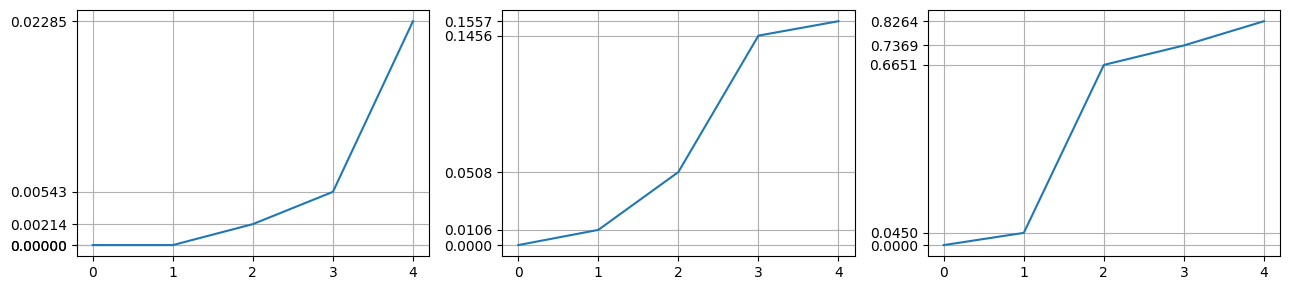

In [12]:
matries_L = [L10, L20, L40]  
fig, ax = plt.subplots(1, 3, figsize = (13,3))
for i,matrix in enumerate(matries_L):
    L_eigenval = deflation_inverse_power_method(matrix ,5)
    ax[i].plot(np.arange(len(L_eigenval)), L_eigenval)
    ax[i].set_yticks(L_eigenval)
    ax[i].grid()
plt.tight_layout()
plt.show()

In [41]:
L10_eigenval, L10_eigenvec = shifting_small_method(L10, 4) #shifting with k = 10 for finding 4 clusters
L20_eigenval, L20_eigenvec = shifting_small_method(L20, 3)
L40_eigenval, L40_eigenvec = shifting_small_method(L40, 2)

U10 = np.array(L10_eigenvec)
U20 = np.array(L20_eigenvec)
U40 = np.array(L40_eigenvec)

899
899
899
899
4
899
899
899
3
899
899
2


In [34]:
elle10= create_L(df.values,10)  #Test
elle20= create_L(df.values,20)  #Test
elle40= create_L(df.values,40)  #Test


np_eigenval_L10, np_eigenvec_L10 = np.linalg.eig(elle10)    #Test
np_eigenval_L20, np_eigenvec_L20 = np.linalg.eig(elle20)    #Test
np_eigenval_L40, np_eigenvec_L40= np.linalg.eig(elle40)     #Test

testU10= np_eigenvec_L10[:, np.argsort(np_eigenval_L10)[:4]]
testU20= np_eigenvec_L20[:, np.argsort(np_eigenval_L20)[:3]]
testU40= np_eigenvec_L40[:, np.argsort(np_eigenval_L40)[:2]]

In [35]:
print(U10.shape)

NameError: name 'U10' is not defined

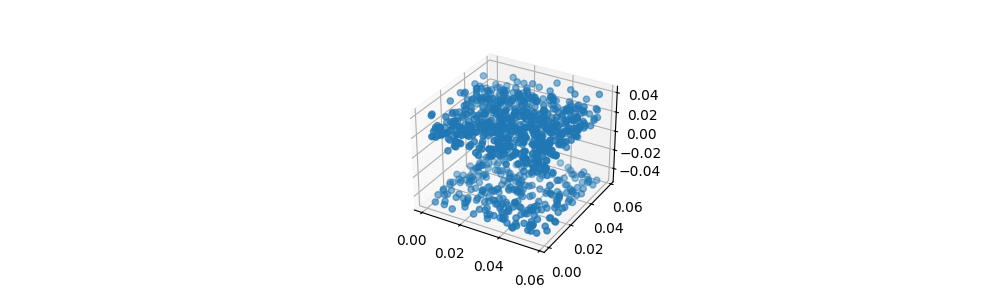

In [42]:
#Shift Method
%matplotlib widget
y10 = U10
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y10[:, 0], y10[:, 1], y10[:, 2])
ax.grid()
plt.show()

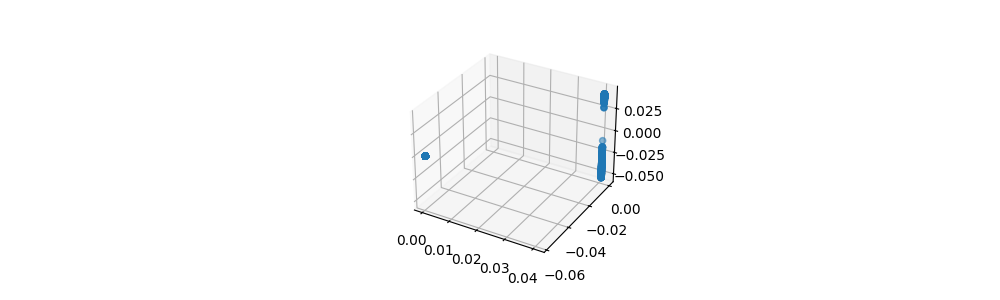

In [43]:
#eig Method
%matplotlib widget
%matplotlib widget
y10 = testU10
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y10[:, 0], y10[:, 1], y10[:, 2])
ax.grid()
plt.show()

(899,)


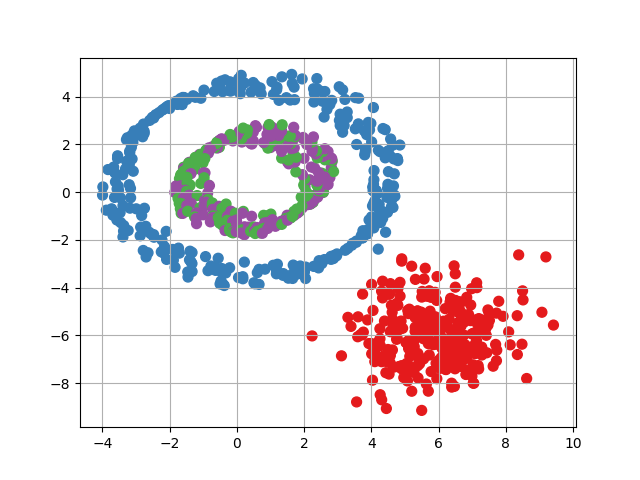

In [43]:
from sklearn.cluster import KMeans
from matplotlib import cm

kmeans10 = KMeans(n_clusters = 4)
clusters = kmeans10.fit_predict(U10)
print(clusters.shape)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(4)}
color_array = np.array([color_to_clusters[cluster] for cluster in clusters])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

(899,)


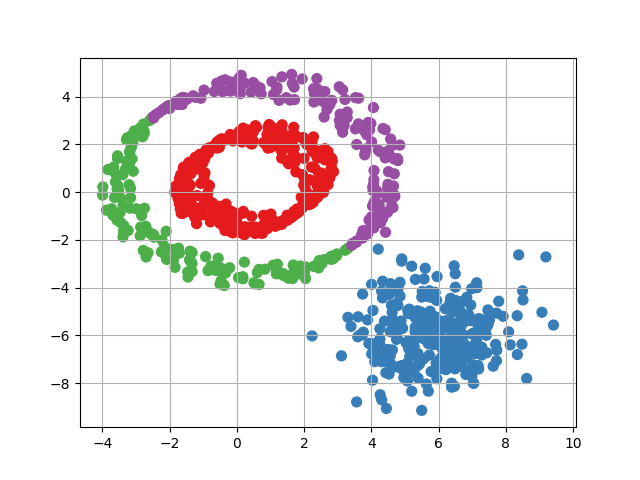

In [45]:
kmeans10_ = KMeans(n_clusters = 4)
clusters = kmeans10_.fit_predict(testU10)
print(clusters.shape)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(4)}
color_array = np.array([color_to_clusters[cluster] for cluster in clusters])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

In [83]:
print(U20.shape)

(899, 3)


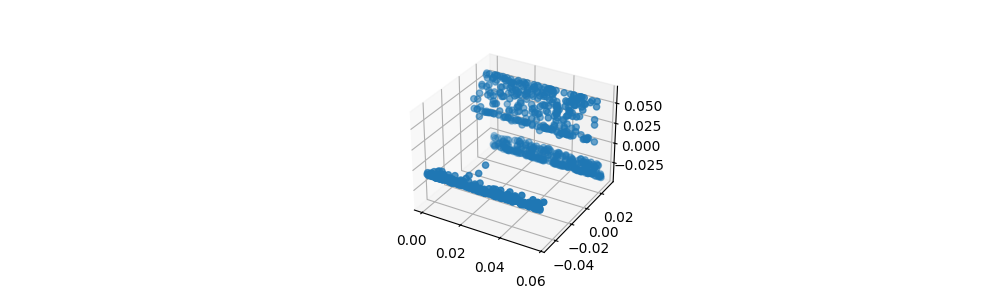

In [46]:
#Using eigenvectors from Shifting method
y20 = U20
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y20[:, 0], y20[:, 1], y20[:, 2])
ax.grid()
plt.show()

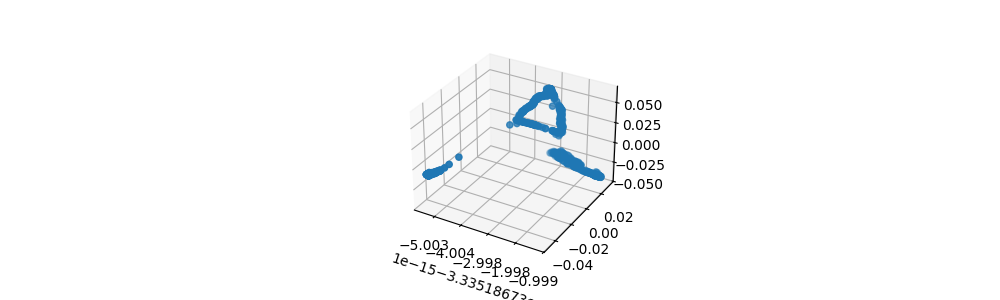

In [47]:
#Testing on TestU20 calculated with eigenvectors from eig method
y20= testU20
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y20[:, 0], y20[:, 1], y20[:, 2])
ax.grid()
plt.show()

(899,)


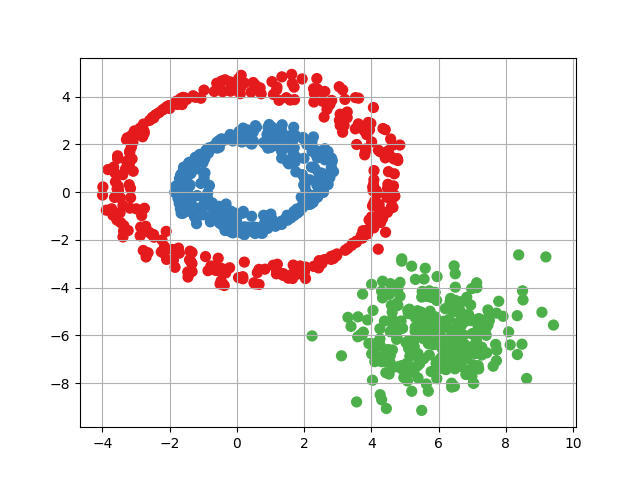

In [48]:
#Kmeans with shift
kmeans20 = KMeans(n_clusters = 3)
clusters = kmeans20.fit_predict(U20)
print(clusters.shape)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(3)}
color_array = np.array([color_to_clusters[cluster] for cluster in clusters])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

(899,)


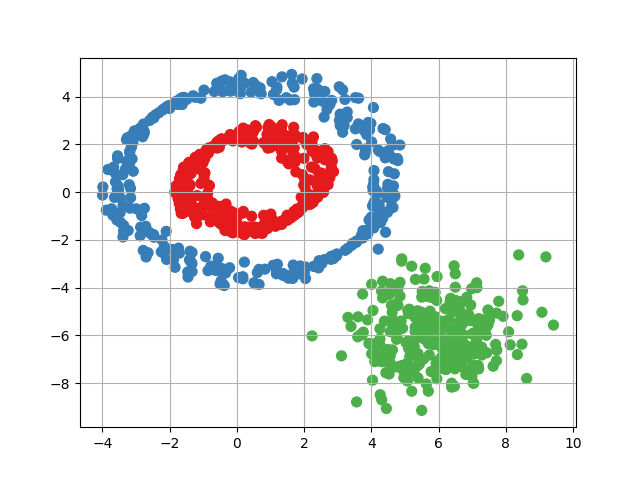

In [49]:
#Kmeans with eig
testkmeans20 = KMeans(n_clusters = 3)
testclusters = testkmeans20.fit_predict(testU20)
print(testclusters.shape)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(3)}
color_array = np.array([color_to_clusters[cluster] for cluster in testclusters])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

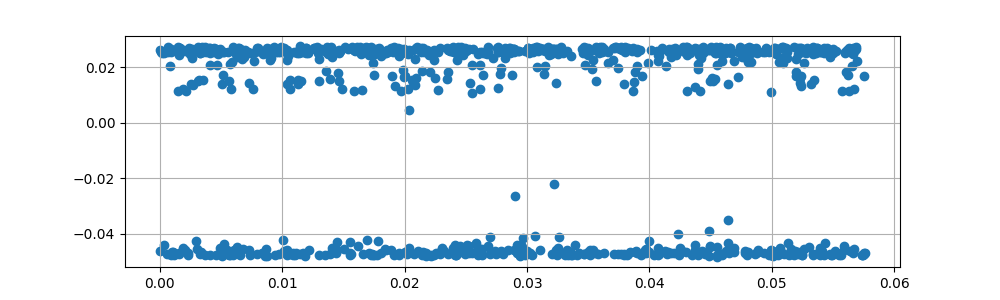

In [50]:
#Shift method
y40 = U40
plt.figure(figsize = (10,3))
plt.scatter(y40[:, 0], y40[:, 1])
plt.grid()
plt.show()

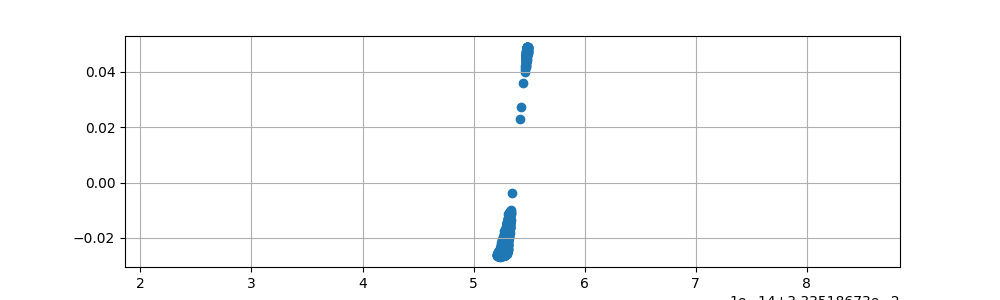

In [51]:
#eig method
y40 = testU40
plt.figure(figsize = (10,3))
plt.scatter(y40[:, 0], y40[:, 1])
plt.grid()
plt.show()

(899,)


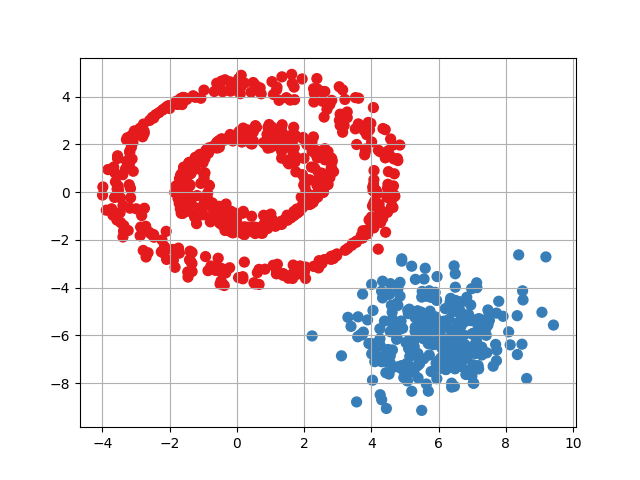

In [52]:
#Shift Method
kmeans40 = KMeans(n_clusters = 2)
clusters = kmeans40.fit_predict(U40)
print(clusters.shape)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(3)}
color_array = np.array([color_to_clusters[cluster] for cluster in clusters])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

(899,)


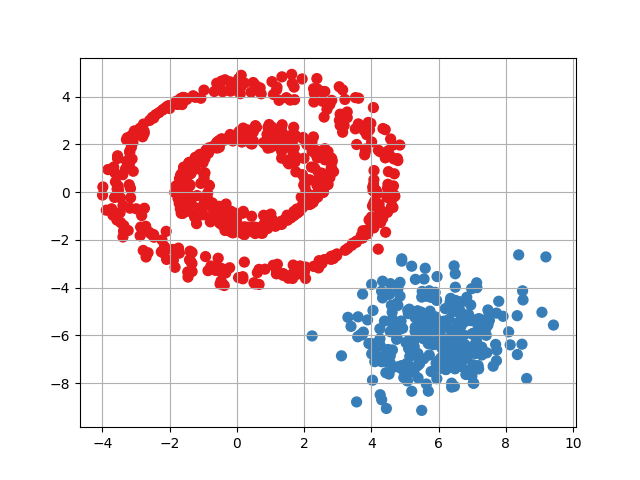

In [53]:
#eig Method
testkmeans40 = KMeans(n_clusters = 2)
testclusters = testkmeans40.fit_predict(testU40)
print(testclusters.shape)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(3)}
color_array = np.array([color_to_clusters[cluster] for cluster in testclusters])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

In [54]:
#OTHER CLUSTERING TECHNIQUES
from sklearn.metrics import silhouette_score
kmeans_ = []
scores = []
k_ = [i+1 for i in range(4)]
for k in k_:
    kmeans = KMeans(n_clusters = k)
    clusters = kmeans.fit_predict(df.values)
    score = silhouette_score(df.values, clusters)
    scores.append(score)
    kmeans_.append(kmeans)

ndx_best = np.argsort(scores)
kmeans_def = kmeans_[ndx_best]
n_clusters = max(k_)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)